In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords, wordnet
from tqdm.notebook import tqdm
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from string import punctuation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import yfinance as yf
from datetime import datetime, timedelta

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [2]:
start_date = (datetime.now() - timedelta(days=31)).strftime('%Y-%m-%d')    
end_date = datetime.now().strftime('%Y-%m-%d')
tesla_stock = yf.Ticker('TSLA')
stock_data = tesla_stock.history(start=start_date, end=end_date)
stock_data.reset_index(inplace=True)
stock_data['Date'] = pd.to_datetime(stock_data['Date'].dt.date)
stock_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2025-03-04,270.929993,284.350006,261.839996,272.040009,126706600,0.0,0.0
1,2025-03-05,272.920013,279.549988,267.709991,279.100006,94042900,0.0,0.0
2,2025-03-06,272.059998,272.649994,260.019989,263.450012,98451600,0.0,0.0
3,2025-03-07,259.320007,266.250000,250.729996,262.670013,102369600,0.0,0.0
4,2025-03-10,252.539993,253.369995,220.000000,222.149994,189076900,0.0,0.0


In [3]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          23 non-null     datetime64[ns]
 1   Open          23 non-null     float64       
 2   High          23 non-null     float64       
 3   Low           23 non-null     float64       
 4   Close         23 non-null     float64       
 5   Volume        23 non-null     int64         
 6   Dividends     23 non-null     float64       
 7   Stock Splits  23 non-null     float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 1.6 KB


## Get the news Data

In [4]:
def get_articles(response):
    articles = []
    for i in range(len(response)):
        articles_dict = {}
        articles_dict['author'] = response[i]['author']
        articles_dict['title'] = response[i]['title']
        articles_dict['desciption'] = response[i]['description']
        articles_dict['url'] = response[i]['url']
        articles_dict['source'] = response[i]['source']['name']
        articles_dict['content'] = response[i]['content']
        articles_dict['pub_date'] = response[i]['publishedAt']
        articles_dict['url'] = response[i]['url']
        articles_dict['photo_url'] = response[i]['urlToImage']
        articles.append(articles_dict)
    return articles

In [5]:
url = 'https://newsapi.org/v2/everything?'
api_key = '9e689cb12ba5409098bf868491266d33'

parameters_headlines = {
    'q': 'Tesla',
    'sortBy':'relevancy',
    'pageSize': 100,
    'apiKey': api_key,
    'language': 'en',
    'from' : start_date
}

In [6]:
response_headline = requests.get(url, params = parameters_headlines)
response_json = response_headline.json()
response_articles = response_json['articles']
df = pd.DataFrame(get_articles(response_articles))

In [7]:
df['pub_date'] = pd.to_datetime(df['pub_date']).dt.date
df['raw_text_combined'] = df['title'].map(str) + " " + df['desciption'].map(str)

In [ ]:
# Preprocessing for sentiment analyzer
def remove_non_ascii(lines):
    return ''.join(i for i in lines if ord(i) < 128)

def cleaning(lines):
    lines = lines.lower() 
    lines = re.sub(r"what's", "what is ", lines) 
    lines = lines.replace('(ap)', '') 
    lines = re.sub(r"\'s", " is ", lines) 
    lines = re.sub(r"\'ve", " have ", lines)
    lines = re.sub(r"can't", "cannot ", lines)
    lines = re.sub(r"n't", " not ", lines)
    lines = re.sub(r"i'm", "i am ", lines)
    lines = re.sub(r"\'re", " are ", lines)
    lines = re.sub(r"\'d", " would ", lines)
    lines = re.sub(r"\'ll", " will ", lines)
    lines = re.sub(r'\W+', ' ', lines) 
    lines = re.sub(r'\s+', ' ', lines) 
    lines = re.sub(r"\\", "", lines) 
    lines = re.sub(r"\'", "", lines) 
    lines = re.sub(r"\"", "", lines) 
    lines = re.sub('[^a-zA-Z ?!]+', '', lines) 
    lines = remove_non_ascii(lines)
    lines = lines.strip() 
    return lines


def remove_stopwords(text):
    stop_words = stopwords.words('english')
    return ' '.join([word for word in text if word not in stop_words])

# grouping together a certain word to its base word
def lemmatizer(word):
    lemmatizer = WordNetLemmatizer()
    return ''.join([lemmatizer.lemmatize(i) for i in word])

# tokenize using regex
tokernizer = RegexpTokenizer(r'\w+') # this will ignore punctuation, spaces, and special symbols

def tokenize(text):
    return tokernizer.tokenize(text)

In [9]:
df['processed_text_combined'] = df['raw_text_combined'].map(cleaning)
df['tokens'] = df['processed_text_combined'].map(tokenize)
df['tokens'] = df['tokens'].map(remove_stopwords)
df['lemms'] = df['tokens'].map(lemmatizer)


In [10]:
df.head()

,author,title,desciption,url,source,content,pub_date,photo_url,raw_text_combined,processed_text_combined,tokens,lemms
0,Andrew J. Hawkins,Is Tesla cooked?,"Tesla stock plunged 15 percent on Monday, its ...",https://www.theverge.com/tesla/627894/tesla-st...,The Verge,"The CEO is absent, the stocks are plummeting, ...",2025-03-11,https://platform.theverge.com/wp-content/uploa...,Is Tesla cooked? Tesla stock plunged 15 percen...,is tesla cooked tesla stock plunged percent o...,tesla cooked tesla stock plunged percent monda...,tesla cooked tesla stock plunged percent monda...
1,Andrew J. Hawkins,Tesla Takedown: all the news about the protest...,"Since early February, Tesla has been the targe...",https://www.theverge.com/news/635249/tesla-tak...,The Verge,"Since early February, Tesla has been the targe...",2025-03-25,https://platform.theverge.com/wp-content/uploa...,Tesla Takedown: all the news about the protest...,tesla takedown all the news about the protests...,tesla takedown news protests roiling automaker...,tesla takedown news protests roiling automaker...
2,Nilay Patel,How the Tesla brand turned so toxic,Today we’re talking about the protests against...,https://www.theverge.com/decoder-podcast-with-...,The Verge,How the Tesla brand turned so toxic\r\nThe Tes...,2025-03-20,https://platform.theverge.com/wp-content/uploa...,How the Tesla brand turned so toxic Today we’r...,how the tesla brand turned so toxic today we r...,tesla brand turned toxic today talking protest...,tesla brand turned toxic today talking protest...
3,Richard Lawler,US attorney general re-announces ‘severe’ char...,As reports of vandalism and even a supposed do...,https://www.theverge.com/news/633445/pam-bondi...,The Verge,But in a scary voice this time.\r\nBut in a sc...,2025-03-20,https://platform.theverge.com/wp-content/uploa...,US attorney general re-announces ‘severe’ char...,us attorney general re announces severe charge...,us attorney general announces severe charges a...,us attorney general announces severe charges a...
4,Richard Lawler,The FBI launched a task force to investigate T...,A report in the New York Post on Monday reveal...,https://www.theverge.com/news/635091/fbi-tesla...,The Verge,The FBI is reportedly looking into incidents o...,2025-03-24,https://platform.theverge.com/wp-content/uploa...,The FBI launched a task force to investigate T...,the fbi launched a task force to investigate t...,fbi launched task force investigate tesla atta...,fbi launched task force investigate tesla atta...


In [11]:
# Load the Roberta Model 
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
def roberta_polarity_scores(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy() # convert logits to numpy array
    scores = softmax(scores) # apply softmax to get probabilities
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2],
        'roberta_compound' : (scores[2] - scores[0])/(scores[2] + scores[0] + scores[1]) # apply normalization
    }
    return scores_dict


sia_analyzer = SentimentIntensityAnalyzer()
def sia_polarity_scores(text):
    sia_polarity = sia_analyzer.polarity_scores(text)
    sia_result = {}
    for key, value in sia_polarity.items():
        sia_result[f'sia_{key}'] = value
    return sia_result

In [16]:
sia_analyzer.polarity_scores("nice suits")

{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'compound': 0.4215}

In [13]:
result = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    processed_text = row['lemms']
    sia_result = sia_polarity_scores(processed_text)    
    raw_text = row['raw_text_combined']
    roberta_result = roberta_polarity_scores(raw_text)
    both = {**sia_result, **roberta_result}
    both['headline'] = row['raw_text_combined']
    both['Date'] = row['pub_date']
    result[i] = both

result = pd.DataFrame(result).T
result

  0%|          | 0/96 [00:00<?, ?it/s]

,sia_neg,sia_neu,sia_pos,sia_compound,roberta_neg,roberta_neu,roberta_pos,roberta_compound,headline,Date
0,0.233,0.767,0.0,-0.765,0.809899,0.171068,0.019033,-0.790865,Is Tesla cooked? Tesla stock plunged 15 percen...,2025-03-11
1,0.108,0.822,0.071,-0.0772,0.628312,0.342045,0.029642,-0.59867,Tesla Takedown: all the news about the protest...,2025-03-25
2,0.147,0.853,0.0,-0.4215,0.714065,0.261223,0.024711,-0.689354,How the Tesla brand turned so toxic Today we’r...,2025-03-20
3,0.206,0.717,0.076,-0.5859,0.497332,0.477686,0.024982,-0.47235,US attorney general re-announces ‘severe’ char...,2025-03-20
4,0.068,0.776,0.155,0.4019,0.167641,0.760605,0.071753,-0.095888,The FBI launched a task force to investigate T...,2025-03-24
...,...,...,...,...,...,...,...,...,...,...
91,0.221,0.779,0.0,-0.7269,0.763391,0.221464,0.015145,-0.748246,Tesla's quarterly sales fall 13%. Experts blam...,2025-04-02
92,0.243,0.592,0.164,-0.296,0.48712,0.460051,0.052829,-0.434291,Tesla Fans Furious at Video of Tesla Crashing ...,2025-03-19
93,0.143,0.788,0.069,-0.3612,0.30348,0.661002,0.035518,-0.267963,Elon Musk meets defence officials in Pentagon ...,2025-03-21
94,0.156,0.844,0.0,-0.34,0.358822,0.607033,0.034145,-0.324676,China Delays BYD Factory in Mexico Over Concer...,2025-03-19


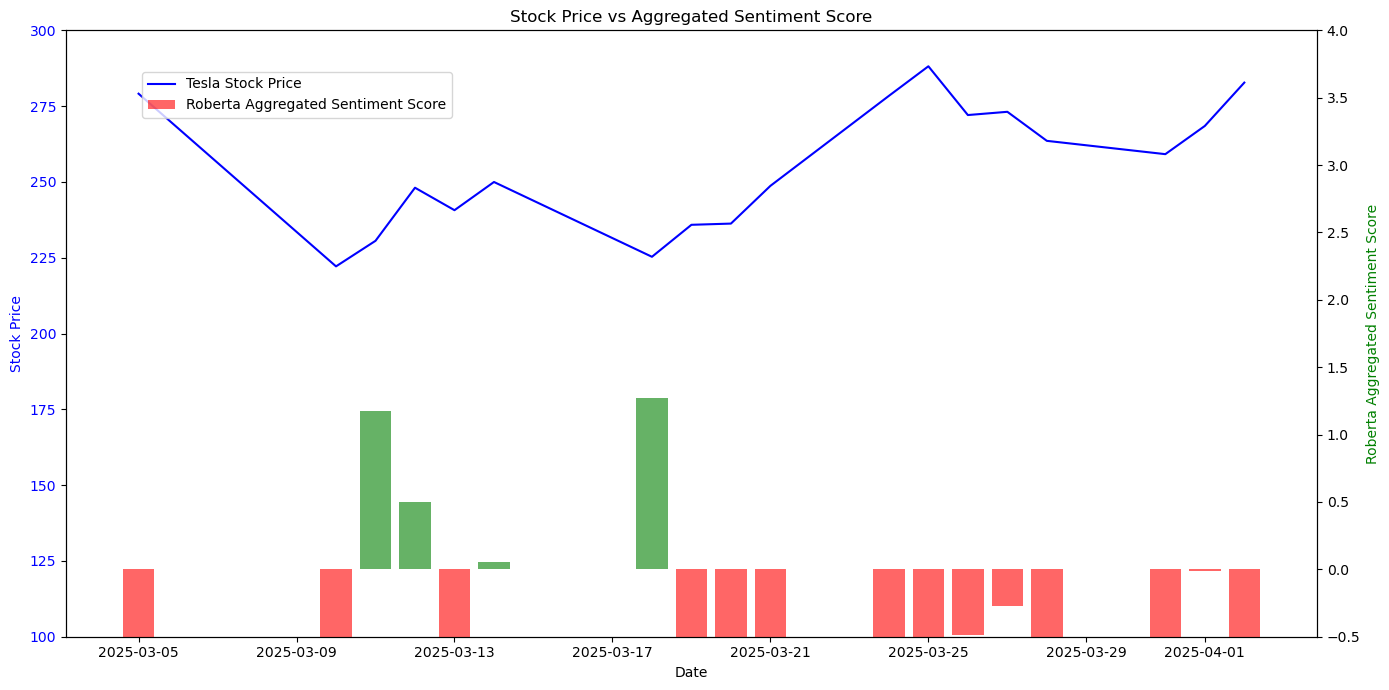

In [14]:
aggregated_data = result.groupby('Date')[['sia_compound','roberta_compound']].sum().reset_index()
aggregated_data['Date'] = pd.to_datetime(aggregated_data['Date'])
df_merge = pd.merge(stock_data[['Close', 'Date']], aggregated_data, on='Date', how='inner')
df_merge = df_merge.sort_values("Date")  # Sort by date

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(14, 7))
# Plot Stock Price as a Line Plot
ax1.plot(df_merge["Date"], df_merge["Close"], color="blue", linestyle="-", label="Tesla Stock Price")
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Price", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_ylim(100, 300)

# Create secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Roberta Aggregated Sentiment Score", color="green")
ax2.bar(df_merge["Date"], df_merge["roberta_compound"], color=df_merge["roberta_compound"].apply(lambda x: 'green' if x > 0 else 'red'), alpha=0.6, label="Roberta Aggregated Sentiment Score")
ax2.set_ylim(-0.5,4)


# Titles & Legends
plt.title("Stock Price vs Aggregated Sentiment Score")
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
fig.tight_layout()
plt.show()


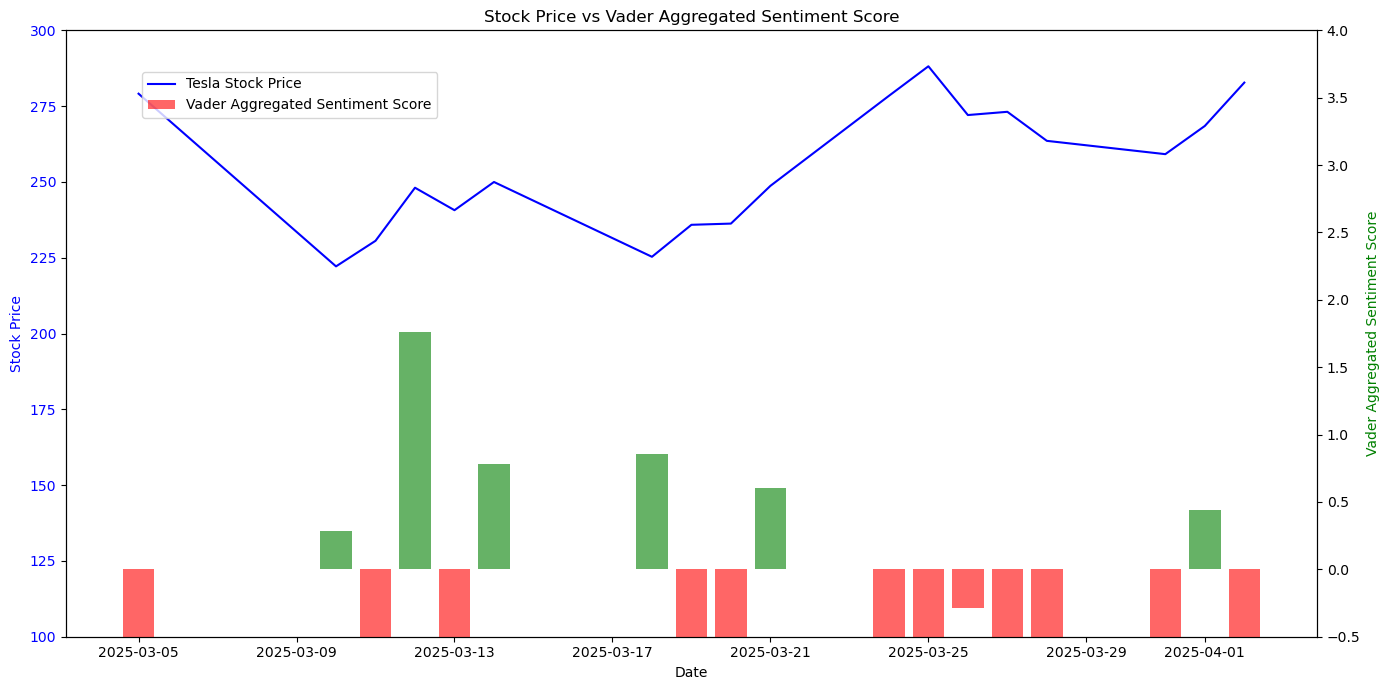

In [15]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(14, 7))
# Plot Stock Price as a Line Plot
ax1.plot(df_merge["Date"], df_merge["Close"], color="blue", linestyle="-", label="Tesla Stock Price")
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Price", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_ylim(100, 300)

# Create secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Vader Aggregated Sentiment Score", color="green")
ax2.bar(df_merge["Date"], df_merge["sia_compound"], color=df_merge["sia_compound"].apply(lambda x: 'green' if x > 0 else 'red'), alpha=0.6, label="Vader Aggregated Sentiment Score")
ax2.set_ylim(-0.5,4)


# Titles & Legends
plt.title("Stock Price vs Vader Aggregated Sentiment Score")
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
fig.tight_layout()
plt.show()
